### **Phần 1: Giải thuật K-Means**

**1. Import thư viện và tập dữ liệu**

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

df = pd.read_csv("OnlineRetail.csv", encoding='latin-1')
df.info()
df.head().style.background_gradient(cmap=sns.cubehelix_palette(as_cmap=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.550000,17850.000000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.390000,17850.000000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.750000,17850.000000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.390000,17850.000000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.390000,17850.000000,United Kingdom


**2. Tiền xử lý dữ liệu**

In [2]:
print("Số lượng giá trị bị thiếu trên mỗi cột:")
print(df.isnull().sum())

Số lượng giá trị bị thiếu trên mỗi cột:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [3]:
print("\nSố lượng hàng bị trùng lặp:")
print(df.duplicated().sum())
print(df[df.duplicated()])


Số lượng hàng bị trùng lặp:
5268
       InvoiceNo StockCode                        Description  Quantity  \
517       536409     21866        UNION JACK FLAG LUGGAGE TAG         1   
527       536409     22866      HAND WARMER SCOTTY DOG DESIGN         1   
537       536409     22900    SET 2 TEA TOWELS I LOVE LONDON          1   
539       536409     22111       SCOTTIE DOG HOT WATER BOTTLE         1   
555       536412     22327  ROUND SNACK BOXES SET OF 4 SKULLS         1   
...          ...       ...                                ...       ...   
541675    581538     22068        BLACK PIRATE TREASURE CHEST         1   
541689    581538     23318     BOX OF 6 MINI VINTAGE CRACKERS         1   
541692    581538     22992             REVOLVER WOODEN RULER          1   
541699    581538     22694                       WICKER STAR          1   
541701    581538     23343       JUMBO BAG VINTAGE CHRISTMAS          1   

             InvoiceDate  UnitPrice  CustomerID         Country  

In [4]:
# Xóa hàng CustomerID bị thiếu và thay thế giá trị thiếu trong Description
df.dropna(subset=['CustomerID'], inplace=True)
df['Description'] = df['Description'].fillna('No Description')
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [5]:
# Chuyển đổi kiểu dữ liệu
df = df[~df['InvoiceNo'].astype(str).str.contains('C', na=False)]
df['InvoiceNo'] = df['InvoiceNo'].astype(int)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='mixed')
df['CustomerID'] = df['CustomerID'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  int64         
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  int64         
 7   Country      397924 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 27.3+ MB


**3. Kỹ thuật đặc trưng**

In [6]:
# Tính tổng tiền cho mỗi đơn hàng
df['Amount'] = df['Quantity'] * df['UnitPrice']
Cid_amount = df.groupby('CustomerID')['Amount'].sum().reset_index()
Cid_amount.head()

,CustomerID,Amount
0,12346,77183.60
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40


In [7]:
# Tính số lần mua hàng của mỗi khách hàng
freq = df.groupby('CustomerID')['InvoiceNo'].count().reset_index()
freq.columns = ['CustomerID', 'Frequency']
freq.head()

,CustomerID,Frequency
0,12346,1
1,12347,182
2,12348,31
3,12349,73
4,12350,17


In [8]:
# Kết hợp dữ liệu 
rfm = pd.merge(Cid_amount, freq, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346,77183.60,1
1,12347,4310.00,182
2,12348,1797.24,31
3,12349,1757.55,73
4,12350,334.40,17


In [9]:
# Tính thời gian kể từ lần mua hàng cuối cùng
df['dif'] = max(df['InvoiceDate']) - df['InvoiceDate']
df['dif'] = df['dif'].dt.days
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,dif
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850,United Kingdom,15.30,697
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34,697
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850,United Kingdom,22.00,697
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34,697
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34,697


In [10]:
# Lấy giá trị thời gian kể từ lần mua hàng cuối cùng cho mỗi khách hàng
last = df.groupby('CustomerID')['dif'].min().reset_index()
last.head()

,CustomerID,dif
0,12346,326
1,12347,40
2,12348,76
3,12349,19
4,12350,311


In [11]:
# Bảng RFM hoàn chỉnh
rfm = pd.merge(rfm, last, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346,77183.60,1,326
1,12347,4310.00,182,40
2,12348,1797.24,31,76
3,12349,1757.55,73,19
4,12350,334.40,17,311


**3. EDA**

In [12]:
rfm.describe()

,CustomerID,Amount,Frequency,Recency
count,4339.000000,4339.000000,4339.000000,4339.000000
mean,15299.936852,2053.793018,91.708689,105.430053
std,1721.889758,8988.248381,228.792852,115.075862
min,12346.000000,0.000000,1.000000,0.000000
25%,13812.500000,307.245000,17.000000,22.000000
50%,15299.000000,674.450000,41.000000,61.000000
75%,16778.500000,1661.640000,100.000000,161.500000
max,18287.000000,280206.020000,7847.000000,697.000000


In [13]:
# Phát hiện ngoại lệ sử dụng IQR
Q1 = rfm[['Recency', 'Frequency', 'Amount']].quantile(0.25)
Q3 = rfm[['Recency', 'Frequency', 'Amount']].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

In [14]:
# Lọc bỏ ngoại lệ
filtered = rfm[
    (rfm['Recency'] >= lower['Recency']) & (rfm['Recency'] <= upper['Recency']) &
    (rfm['Frequency'] >= lower['Frequency']) & (rfm['Frequency'] <= upper['Frequency']) &
    (rfm['Amount'] >= lower['Amount']) & (rfm['Amount'] <= upper['Amount'])
]

In [15]:
filtered.describe()

,CustomerID,Amount,Frequency,Recency
count,3682.000000,3682.000000,3682.000000,3682.000000
mean,15312.727594,843.231226,50.756382,106.373438
std,1714.182234,784.852084,47.376080,96.497657
min,12348.000000,0.000000,1.000000,0.000000
25%,13827.250000,281.935000,15.000000,25.000000
50%,15312.500000,570.480000,34.000000,72.000000
75%,16799.000000,1142.847500,73.000000,172.000000
max,18287.000000,3692.280000,223.000000,363.000000


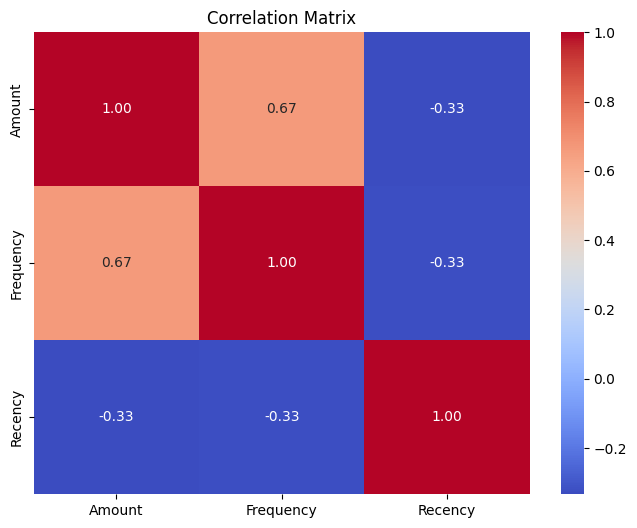

In [17]:
# Heatmap: Xem tương quan giữa các biến
plt.figure(figsize=(8, 6))
sns.heatmap(filtered[['Amount', 'Frequency', 'Recency']].corr(), 
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Pairplot: Phân bố các cụm
fig = px.scatter_matrix(
    filtered,
    dimensions=['Amount', 'Frequency', 'Recency'],
    color="CustomerID",
    title="Scatter Matrix (Tổng quan dữ liệu)",
    color_discrete_sequence=['#491D8B', '#EB548C']
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [ ]:
main_color = ['#491D8B'] 

# --- RECENCY ---

# 1. Box-plot: Recency
fig = px.box(data_frame=filtered, 
             y='Recency', 
             color_discrete_sequence=main_color,
             title='Box-plot: Recency Distribution')
fig.show()

# 2. Histogram: Recency Distribution
fig = px.histogram(data_frame=filtered, 
                   x='Recency',
                   color_discrete_sequence=main_color,
                   nbins=50,
                   title='Histogram: Recency Distribution')
fig.update_layout(bargap=0.1) 
fig.show()

# --- AMOUNT ---

# 3. Box-plot: Amount
fig = px.box(data_frame=filtered, 
             y='Amount',
             color_discrete_sequence=main_color,
             title='Box-plot: Amount Distribution')
fig.show()

# 4. Histogram: Amount Distribution
fig = px.histogram(data_frame=filtered, 
                   x='Amount',
                   color_discrete_sequence=main_color,
                   nbins=50,
                   title='Histogram: Amount Distribution')
fig.update_layout(bargap=0.1)
fig.show()

# --- FREQUENCY ---

# 5. Box-plot: Frequency
fig = px.box(data_frame=filtered, 
             y='Frequency', 
             color_discrete_sequence=main_color,
             title='Box-plot: Frequency Distribution')
fig.show()

# 6. Histogram: Frequency Distribution
fig = px.histogram(data_frame=filtered, 
                   x='Frequency',
                   color_discrete_sequence=main_color,
                   nbins=50,
                   title='Histogram: Frequency Distribution')
fig.update_layout(bargap=0.1)
fig.show()

# --- SCATTER PLOTS (Tương quan) ---

# 7. Scatter Plot: Recency vs Frequency
fig = px.scatter(data_frame=filtered, 
                 x='Recency', y='Frequency',
                 size='Amount',           # Kích thước điểm dựa trên tổng tiền mua
                 hover_name='CustomerID', 
                 template='seaborn',
                 color_discrete_sequence=main_color,
                 title='Scatter: Recency vs Frequency (Size = Amount)')
fig.update_layout(width=800, height=600,
                  xaxis=dict(color="#BF40BF"), yaxis=dict(color="#BF40BF"))
fig.show()

# 8. Scatter Plot: Recency vs Amount
fig = px.scatter(data_frame=filtered, 
                 x='Recency', y='Amount',
                 size='Frequency',        # Kích thước điểm dựa trên tần suất mua
                 hover_name='CustomerID', 
                 template='seaborn',
                 color_discrete_sequence=main_color,
                 title='Scatter: Recency vs Amount (Size = Frequency)')
fig.update_layout(width=800, height=600,
                  xaxis=dict(color="#BF40BF"), yaxis=dict(color="#BF40BF"))
fig.show()

**4. Tìm số cụm tối ưu và huấn luyện mô hình**

In [22]:
from sklearn.preprocessing import StandardScaler

rfm = filtered[['Amount', 'Frequency', 'Recency']]
scaler = StandardScaler()
rfm_scaled_array = scaler.fit_transform(rfm)

rfm_scaled = pd.DataFrame(
    rfm_scaled_array, 
    columns=['Amount', 'Frequency', 'Recency'],
    index=rfm.index  
)

rfm_scaled.head()


,Amount,Frequency,Recency
2,1.215692,-0.417068,-0.314801
3,1.165115,0.469575,-0.905569
4,-0.648403,-0.712616,2.120822
5,2.118915,0.722902,-0.345894
6,-0.961116,-0.987054,1.011836


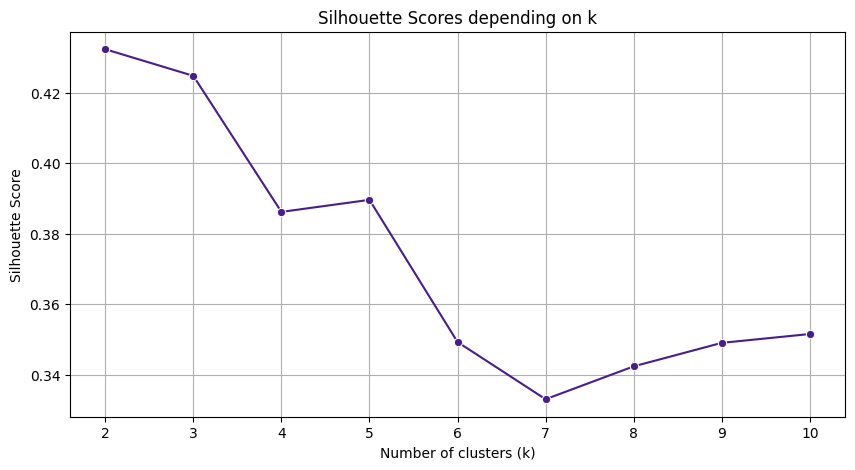

In [28]:
from sklearn.metrics import silhouette_score

#  Tính toán Silhouette Score 
km_scores = []
k_range = range(2, 11)  

for i in k_range:
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled) 
    
    # Tính score và lưu lại
    score = silhouette_score(rfm_scaled, kmeans.labels_)
    km_scores.append(score)

# Vẽ biểu đồ Silhouette (Code của bạn) 
plt.figure(figsize=(10, 5))
sns.lineplot(x=k_range, y=km_scores, marker='o', color='#491D8B') # Thêm marker='o' cho dễ nhìn
plt.title('Silhouette Scores depending on k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Phương pháp Elbow 
sse = []
for i in range(1, 11): 
    kmeans = KMeans(n_clusters=i, max_iter=300, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

fig = px.line(x=range(1, 11), y=sse, template="seaborn", title='Elbow Method')
fig.update_layout(width=800, height=600, 
                  title_font_color="#BF40BF",
                  xaxis=dict(color="#BF40BF", title="Clusters"),
                  yaxis=dict(color="#BF40BF", title="SSE"))
fig.show()



In [33]:
#  Chạy mô hình cuối cùng 
kmeans_final = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters = kmeans_final.fit_predict(rfm_scaled)

In [ ]:
import plotly.graph_objects as go

model_used = kmeans_final 
fig = go.Figure()

colors = ['#FF6B6B', '#4ECDC4', '#FFD93D']  # Màu cho 3 cụm

# 1. Vẽ các điểm dữ liệu (Scatter 3D)
for i in range(3):
    fig.add_trace(go.Scatter3d(
        x=rfm_scaled.iloc[clusters == i, 0], # Cột Amount
        y=rfm_scaled.iloc[clusters == i, 1], # Cột Frequency
        z=rfm_scaled.iloc[clusters == i, 2], # Cột Recency (Trục thứ 3)
        mode='markers',
        marker=dict(color=colors[i], size=4, opacity=0.6), # Giảm size và opacity để dễ nhìn xuyên thấu
        name=f'Cụm {i}'
    ))

# 2. Vẽ tâm cụm (Centroids) 
fig.add_trace(go.Scatter3d(
    x=model_used.cluster_centers_[:, 0],
    y=model_used.cluster_centers_[:, 1],
    z=model_used.cluster_centers_[:, 2],
    mode='markers+text',
    marker=dict(color='white', size=10, symbol='x', line=dict(width=5, color='yellow')),
    text=[f'Center {i}' for i in range(3)],
    name='Tâm cụm'
))

fig.update_layout(
    template='plotly_dark',
    width=1000, height=800,
    title='<b>K-Means Clustering Results (3D View)</b>',
    scene=dict(
        xaxis_title='Amount (Scaled)',
        yaxis_title='Frequency (Scaled)',
        zaxis_title='Recency (Scaled)'
    )
)
fig.show()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

centers = kmeans_final.cluster_centers_

# Xác định thứ tự cột trong rfm_scaled 
# 0: Amount, 1: Frequency, 2: Recency
cols = ['Amount', 'Frequency', 'Recency']
colors = ['#FF6B6B', '#4ECDC4', '#FFD93D'] # Màu cho 3 cụm

# Tạo khung 3 biểu đồ con (1 hàng 3 cột)
fig = make_subplots(rows=1, cols=3, 
                    subplot_titles=('Amount vs Frequency', 'Frequency vs Recency', 'Recency vs Amount'))

# --- VÒNG LẶP VẼ TỪNG CỤM ---
for i in range(3): # Lặp qua 3 cụm (0, 1, 2)
    mask = (clusters == i) # Lọc dữ liệu thuộc cụm i
    
    # Biểu đồ 1: Amount (x) vs Frequency (y)
    fig.add_trace(go.Scatter(
        x=rfm_scaled.loc[mask, 'Amount'], 
        y=rfm_scaled.loc[mask, 'Frequency'],
        mode='markers', marker=dict(color=colors[i], size=6, opacity=0.6),
        name=f'Cụm {i}', showlegend=(i==0) 
    ), row=1, col=1)

    # Biểu đồ 2: Frequency (x) vs Recency (y)
    fig.add_trace(go.Scatter(
        x=rfm_scaled.loc[mask, 'Frequency'], 
        y=rfm_scaled.loc[mask, 'Recency'],
        mode='markers', marker=dict(color=colors[i], size=6, opacity=0.6),
        name=f'Cụm {i}', showlegend=False
    ), row=1, col=2)

    # Biểu đồ 3: Recency (x) vs Amount (y)
    fig.add_trace(go.Scatter(
        x=rfm_scaled.loc[mask, 'Recency'], 
        y=rfm_scaled.loc[mask, 'Amount'],
        mode='markers', marker=dict(color=colors[i], size=6, opacity=0.6),
        name=f'Cụm {i}', showlegend=False
    ), row=1, col=3)

# --- VẼ TÂM CỤM (CENTROIDS) ---
# Tâm biểu đồ 1 (Cột 0 vs Cột 1)
fig.add_trace(go.Scatter(
    x=centers[:, 0], y=centers[:, 1],
    mode='markers', marker=dict(color='black', size=12, symbol='x', line=dict(width=2, color='white')),
    name='Tâm cụm'
), row=1, col=1)

# Tâm biểu đồ 2 (Cột 1 vs Cột 2)
fig.add_trace(go.Scatter(
    x=centers[:, 1], y=centers[:, 2],
    mode='markers', marker=dict(color='black', size=12, symbol='x', line=dict(width=2, color='white')),
    showlegend=False
), row=1, col=2)

# Tâm biểu đồ 3 (Cột 2 vs Cột 0)
fig.add_trace(go.Scatter(
    x=centers[:, 2], y=centers[:, 0],
    mode='markers', marker=dict(color='black', size=12, symbol='x', line=dict(width=2, color='white')),
    showlegend=False
), row=1, col=3)

# Cập nhật giao diện
fig.update_layout(title_text="Phân tích chi tiết từng cặp biến (2D Views)", 
                  template='plotly_dark', height=500, width=1200)
fig.show()

### **Phần 2: Phân cụm đa cấp**

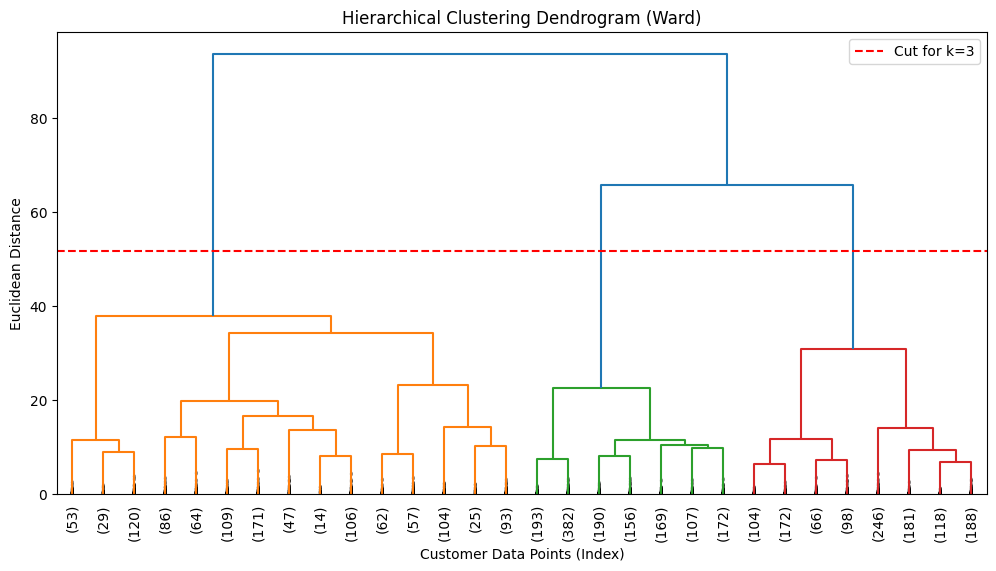

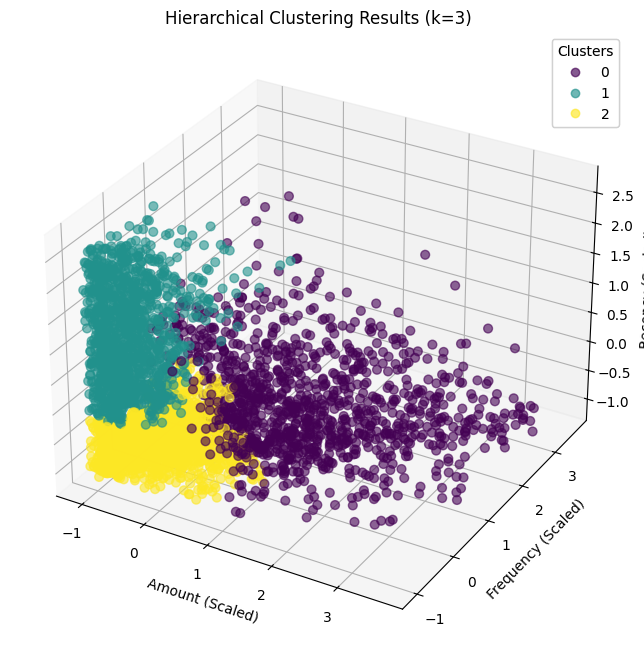

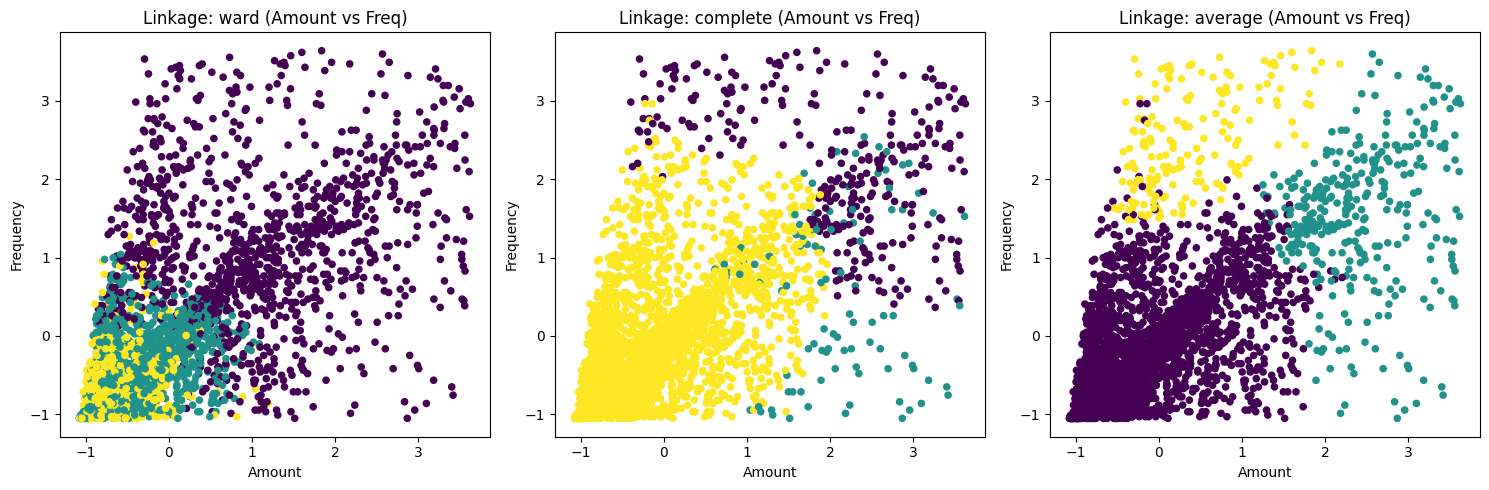

In [40]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering

X = rfm_scaled[['Amount', 'Frequency', 'Recency']] 
X_array = X.values

k_optimal = 3 

# Tính toán ma trận khoảng cách (Linkage) 

distances = linkage(X_array, method="ward", metric="euclidean")

#  Vẽ Dendrogram (Cây phân cấp)
plt.figure(figsize=(12, 6))
plt.title('Hierarchical Clustering Dendrogram (Ward)')
plt.xlabel('Customer Data Points (Index)')
plt.ylabel('Euclidean Distance')

# Vẽ dendrogram
dendrogram(
    distances,
    truncate_mode='lastp',  # Chỉ hiển thị p nhánh cuối cùng cho gọn
    p=30,                   # Hiển thị 30 nhánh cuối
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True
)

# Vẽ đường cắt để xác định k cụm
if len(distances) >= k_optimal:
    dist_threshold = (distances[-k_optimal+1, 2] + distances[-k_optimal, 2]) / 2
    plt.axhline(y=dist_threshold, c='r', linestyle='--', label=f'Cut for k={k_optimal}')
    plt.legend()

plt.show()

# Áp dụng Phân cụm (Agglomerative Clustering)

ac = AgglomerativeClustering(n_clusters=k_optimal, linkage="ward")
labels = ac.fit_predict(X_array)

# Vẽ biểu đồ kết quả (3D SCATTER PLOT) 
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot 3D
scatter = ax.scatter(X_array[:, 0], X_array[:, 1], X_array[:, 2], 
                     c=labels, cmap='viridis', s=40, alpha=0.6)

# Đặt tên trục 
ax.set_xlabel('Amount (Scaled)')
ax.set_ylabel('Frequency (Scaled)')
ax.set_zlabel('Recency (Scaled)')
ax.set_title(f'Hierarchical Clustering Results (k={k_optimal})')

# Thêm thanh màu 
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()


methods = ['ward', 'complete', 'average'] 

plt.figure(figsize=(15, 5))
for i, method in enumerate(methods):
    # Tính linkage
    Z = linkage(X_array, method=method)
    # Cắt cụm
    clus = fcluster(Z, k_optimal, criterion="maxclust")
    
    # Vẽ subplot
    plt.subplot(1, 3, i+1)
    plt.scatter(X_array[:, 0], X_array[:, 1], c=clus, cmap='viridis', s=20)
    plt.title(f'Linkage: {method} (Amount vs Freq)')
    plt.xlabel('Amount')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### **Phần 3: So sánh K-Means và Phân cụm Đa cấp**

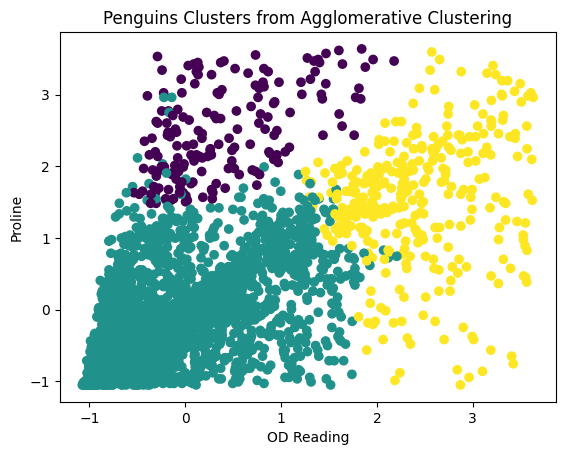

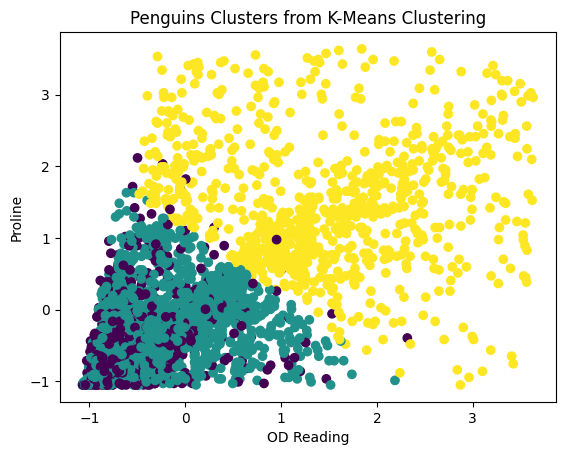

Silhouette Scores for Penguins Dataset:

K-Means Clustering:  0.42490932892126804
Agg Clustering:  0.41840363366620575


In [41]:
# --- 1. Import và load dữ liệu Penguins ---
from sklearn.metrics import silhouette_score


# --- 2. Phân cụm Đa cấp (Agglomerative) ---
ac = AgglomerativeClustering(n_clusters=3, linkage='average')
ac_clusters = ac.fit_predict(X)

# Hiển thị kết quả Agglomerative
plt.scatter(X.values[:,0], X.values[:,1], c=ac_clusters)
plt.title("Penguins Clusters from Agglomerative Clustering")
plt.xlabel("OD Reading")
plt.ylabel("Proline")
plt.show()

# --- 3. Phân cụm K-Means ---
km = KMeans(n_clusters=3)
km_clusters = km.fit_predict(X)

# Hiển thị kết quả K-Means
plt.scatter(X.values[:,0], X.values[:,1], c=km_clusters)
plt.title("Penguins Clusters from K-Means Clustering")
plt.xlabel("OD Reading")
plt.ylabel("Proline")
plt.show()

# --- 4. So sánh bằng chỉ số Silhouette ---
print("Silhouette Scores for Penguins Dataset:\n")
print("K-Means Clustering: ", silhouette_score(X, km_clusters))
print("Agg Clustering: ", silhouette_score(X, ac_clusters))